#### 1. 应当输入什么给网络
输入的肯定是图像信息，但是需要原始的图像信息需要经过一些处理以及格式变换才能作为输出，其实这个过程中维度的变化倒不是很大（可能会resize），主要是经过处理后的图像所包含的信息的一些处理。

因为可能会对图像进行很多操作，添加一些功能之类的，而且我们当然希望这些操作是可拓展的，所以说最好定义一个输入图像的类，然后需要什么功能就在类中为它定义函数，将最终的输出图像作为这个类一个属性，这样操作起来会非常方便。

1.1 加载数据集中各类图片的存储路径

In [ ]:
import os
import glob

# save the cornell grasping dataset
cornell_path = '../../../../grasping_dataset/Conell_grasping_dataset'
cpos_path = glob.glob(os.path.join(cornell_path, '*', 'pcd*cpos.txt'))
cpos_path.sort()
# data_path store all path of pcd*cpos.txt kind files
rgb_path = [filename.replace('cpos.txt','r.png') for filename in cpos_path]
depth_path = [filename.replace('cpos.txt','d.tiff') for filename in cpos_path]

1.2 定义一个加载数据集的类，此类可拓展

In [ ]:
import cv2
import numpy as np
class Image:
    '''
    定义一个图像类，主要功能是将原始的图像输入转化为适合网络训练的格式
    并根据图像处理需求完成一些其他功能
    '''
    def __init__(self, img):
        '''
        :功能 :类初始化函数
        :参数 :ndarray,原始图像
        '''
        self.img = img
    
    @classmethod #注意，使用cls的时候要在该函数前面加装饰器声明
    def from_file(cls, file_path):
        '''
        :功能           : 从原始图片的路径对其进行载入
        :参数 file_path : str,原始图像所在的路径
        :返回 class     : 由指定路径的原始图片实例化的Image类
        :备注           : 这里用到的cls方法要学习一下
        '''
        return cls(cv2.imread(file_path))  

1.3 图片预处理class的测试

In [ ]:
#第一种方法，直接传入原始图像来初始化
img = cv2.imread(rgb_path[0])

class1 = Image(img)
class2 = Image.from_file(rgb_path[0])

print(class1.img.shape)
print(class2.img.shape)
      
print(class1.img == class2.img)

1.4 扩展class类的功能

In [ ]:
from imageio import imread
import numpy as np
class Image:
    '''定义一个图像类，主要功能是将原始的图像输入转化为适合网络训练的格式并根据图像处理需求完成一些其他功能'''
    def __init__(self,img):
        '''
        :功能 :类初始化函数
        :参数 :ndarray,原始图像
        '''
        self.img = img
    
    @classmethod
    def from_file(cls,file_path):
        '''
        :功能           : 从原始图片的路径对其进行载入
        :参数 file_path : str,原始图像所在的路径
        :返回 class     : 由指定路径的原始图片实例化的Image类
        :备注           : 这里用到的cls方法要学习一下
        '''
        return cls(imread(file_path))
    
    def img_format(self):
        '''
        :功能 :将原始图像转换为指定格式
        '''
        pass
    
    def normalize(self):
        '''
        :功能 :将图像像素值标准化至[-1,1]范围
        '''
        self.img = self.img.astype('float32')/255.0
        self.img = self.img-self.img.mean()
        
    def crop(self):
        '''
        :功能 :对图像进行裁剪操作
        '''
        pass

In [ ]:
#测试标准化函数的功能：

rgbclass = Image.from_file(rgb_path[0])

print('标准化之前均值为%.3f' % rgbclass.img.mean())
print('标准化之前最大值为%d，最小值为%d' % (rgbclass.img.max(),rgbclass.img.min()))

rgbclass.normalize()

print('标准化之后均值为%.3f' % rgbclass.img.mean())
print('标准化之后最大值为%.3f，最小值为%.3f' % (rgbclass.img.max(),rgbclass.img.min()))

print(rgbclass.img.shape)

In [ ]:
class DepthImage(Image):
    '''深度图像类，读取，载入，正则等预处理都是一样的，后面可能会添加一些针对深度图的专属处理功能'''
    def __init__(self,img):
        super(DepthImage,self).__init__(img)
        
    @classmethod
    def from_file(cls,file_path):
        '''
        :功能           : 从原始图片的路径对其进行载入
        :参数 file_path : str,原始图像所在的路径
        :返回 class     : 由指定路径的原始图片实例化的Image类
        :备注           : 这里用到的cls方法要学习一下
        '''
        return cls(imread(file_path))
    
    def normalize(self):
        '''
        :功能 :将图像像素值标准化至[0,1]范围
        '''
        self.img = self.img.astype('float32')/255.0
        self.img = self.img-self.img.mean()

In [ ]:
a = DepthImage.from_file(depth_path[0])
print(a.img.shape)

#### 2. 如何设置网络的输出参数

网络的输出肯定是根据设置的表征参数来做的，也就是你怎么去定义一个抓取，比如这里的抓取通常使用五维信息参数（$(x,y,\theta,width,h)$h这个参数没什么意思，就是夹爪的指宽度，所以关键的信息就是四个$(x,y,\theta,width)$，我们选择这四个参数来确定一个抓取，而网络最终的预测输出要是一个抓取，那么网络最终的预测输出值就应该是这几个值的预测结果。所以，需要将现有的标注信息转化为本方法中所选择表征方法的几个参数，同时，对图像进行预处理做数据增强时应该保证这些标注也同步进行处理，因此，最好也定义一个类来对数据进行处理，功能就是将现有的标注转化为所需要的标注，同时，要有一些预处理的操作。

首先还是一个一个地来，定义一个类，输入为一个抓取框的四个角点（每个点有两个坐标，所以共八个数据）信息，然后功能就是从这些点的坐标中提取出想要的信息。

后面程序中所用到的(x0,y0)即对应图中的右上角点

为了方便处理，这个类的输入设置为角点的坐标信息，要经过一步预先的提取，这一步上次的程序已经做过了，这里直接复制过来


In [ ]:
def str2num(point):
    '''
    :功能  :将字符串类型存储的抓取框脚点坐标取整并以元组形式返回
    
    :参数  :point,字符串，以字符串形式存储的一个点的坐标
    :返回值 :列表，包含int型抓取点数据的列表[x,y]
    '''
    x,y = point.split()
    x,y = int(round(float(x))),int(round(float(y)))
    
    return np.array([x,y])

def get_rectangles(cornell_grasp_file):
    '''
    :功能  :从抓取文件中提取抓取框的坐标信息
    
    :参数  :cornell_grap_file:字符串，指向某个抓取文件的路径
    :返回值 :列表，包含各个抓取矩形数据的列表
    '''
    grasp_rectangles = []
    with open(cornell_grasp_file,'r') as f:
        while True:
            grasp_rectangle = []
            point0 = f.readline().strip()
            if not point0:
                break
            point1,point2,point3 = f.readline().strip(),f.readline().strip(),f.readline().strip()
            grasp_rectangle = np.array([str2num(point0),
                               str2num(point1),
                               str2num(point2),
                               str2num(point3)])
            grasp_rectangles.append(grasp_rectangle)
    
    return grasp_rectangles


In [ ]:
#测试一下这个程序的功能是否符合预期

rectangles0 = get_rectangles(cpos_path[0])

print(type(rectangles0[0]))
print(rectangles0[0].shape)
print(rectangles0[0])
print(rectangles0)

#这里可以看出，rectangles0中的每个元素都是我们需要的一个四个点数据

2.1 定义并测试抓取框参数的处理类

In [ ]:
import numpy as np

class Grasp:
    '''
    定义一个抓取框处理类，主要功能是将原始的抓取框标注信息转化为训练所定义的表征信息，如中心位置，
    面积角度等，并根据图像处理需求完成一些相应的其他功能
    '''
    def __init__(self,points):
        '''
        :功能        : 类初始化函数
        :参数 points : 2darry,定义一个抓取框的四个角点坐标信息[[x1,y1],[x2,y2],[x3,y3],[x4,x4]]
        '''
        self.points = points

In [ ]:
gr = Grasp(rectangles0[0])
gr.points

首先计算抓取矩形框中心坐标，也就是计算这四个点的x均值和y均值，这个通过一行代码就可以实现

In [ ]:
center = np.mean(gr.points,axis = 0).astype(np.int)
print(center) 

然后计算抓取框的宽度（对应二指夹爪张开的宽度），只需要计算出对边的长度就行了，这里在前面实验的时候发现第一个点(x0,y0)到第二个点(x1,y1)，第三个点到第四个点代表的就是我们想要的机械爪张开宽度，所以，直接计算即可

In [ ]:
x0,y0 = gr.points[0][0],gr.points[0][1]
x1,y1 = gr.points[1][0],gr.points[1][1]

dx = x0-x1
dy = y0-y1

width = np.sqrt(dx**2+dy**2)

print(width)

然后是抓取框的长度，虽然没什么用，但还是可以计算一下，通过第二个点到第三个点之间的距离计算即可

In [ ]:
x1,y1 = gr.points[1][0],gr.points[1][1]
x2,y2 = gr.points[2][0],gr.points[2][1]

dx = x2-x1
dy = y2-y1

length = np.sqrt(dx**2+dy**2)

print(length)

再次明确一下:在我这里,

gr.width表示的是手爪抓取时的张开宽度,也就是标注框的第一个点(x0,y0)与第二个点(x1,y1)之间连线的长度; gr.length表示的是手指的宽度,也就是标注框的第二个点(x1,y1)与第三个点(x2,y2)之间连线的长度;



此外，关于角度，即使是和x轴的夹角，同一个条线也会两个不同的结果，但是这两个角是等价的，所以取其一便好，选择与x轴正方向的夹角即可，下面的这行代码的意思就是，计算出最终的角度并将其角度转换为了与x轴正方向所成的锐角，我直接从gg-cnn中摘抄过来了。

In [ ]:
x0,y0 = gr.points[0][0],gr.points[0][1]
x1,y1 = gr.points[1][0],gr.points[1][1]

dx = x0-x1
dy = y0-y1

#我觉得这个地方给y加个负号是没有意义的，因为如上图所示，标注的情况是有很多种的，你也不知道最终dy是正是负，最后只要保证预测和标注处理方法一致就行了，当然，也可能作者有什么高见我没看懂。
#angle = ((np.arctan2(-dy,dx) + np.pi/2) % np.pi - np.pi/2)/np.pi*180 如果要输出角度制的话就用这行代码
angle = ((np.arctan2(-dy,dx) + np.pi/2) % np.pi - np.pi/2)
print(angle)

In [ ]:
import numpy as np
from skimage.draw import polygon


class Grasp:
    '''定义一个抓取框处理类，主要功能是将由四个角点坐标定义的原始的抓取框提取转化为训练所定义的表征信息，如中心位置，面积角度等，并根据图像处理需求完成一些相应的其他功能'''
    def __init__(self,points):
        '''
        :功能        : 类初始化函数
        :参数 points : 2darry,定义一个抓取框的四个角点坐标信息[[x1,y1],[x2,y2],[x3,y3],[x4,x4]]
        '''
        self.points = points
       
    @property#类装饰器，可以让一个类的方法以属性的方式被调用
    def center(self):
        '''
        :功能          : 计算本类中所包含的抓取框的中心点
        :返回 1darray  : 本类所包含抓取框的中心点array[x,y]
        '''
        center = np.mean(self.points,axis = 0).astype(np.int)
        return center
    
    @property
    def width(self):
        '''
        :功能          : 计算本类中所包含的抓取框手指张开宽度width
        :返回 1darray  : 本类所包含抓取框的长度[width]
        '''
        #第二个点和第三个点之间的间距长度
        dx = self.points[0][0] - self.points[1][0]
        dy = self.points[0][1] - self.points[1][1]
        
        return np.sqrt(dx**2+dy**2)
    
    @property
    def length(self):
        '''
        :功能          : 计算本类中所包含的抓取框长度(手指张开宽度width的邻边)
        :返回 1darray  : 本类所包含抓取框的长度[length]
        '''
        #第二个点和第三个点之间的间距长度
        dx = self.points[1][0] - self.points[2][0]
        dy = self.points[1][1] - self.points[2][1]
        
        return np.sqrt(dx**2+dy**2)
    
    @property
    def angle(self):
        '''
        :功能          : 计算本类中所包含的抓取框相对于x轴正方向的偏转角度
        :返回 1darray  : 本类所包含抓取框的旋转角度（弧度值）
        ''' 
        
        dx = self.points[0][0] - self.points[1][0]
        dy = self.points[0][1] - self.points[1][1]
        
        return (np.arctan2(-dy,dx) + np.pi/2) % np.pi - np.pi/2
    
    def compact_polygon_coords(self,shape):
        '''
        :功能          : 计算并返回本抓取矩形内部点的坐标
        :参数 shape    : tuple, optional.Image shape which is used to determine the maximum extent of output pixel coordinates.
        :返回 ndarray  : rr,cc 本抓取框内部点的行列坐标
        ''' 
        return polygon(self.points[:,0],self.points[:,1],shape)


In [ ]:
# Grasp类的测试
gr = Grasp(rectangles0[0])
gr.points
gr.center
gr.width
gr.length
gr.angle

有了这些参数之后，如何将其构建成为输出是一个值得考虑的问题，我之前一直想不懂该怎么搞，看了ggcnn之后才明白，是这样的，每个抓取框都是由上面的这几个参数完全定义的，而且抓取框也覆盖了图中的一个矩形范围，那么我就针对每个参数都生成一张映射图，比如一张图就代表角度，没有抓取框的区域，像素值全为0，有抓取框覆盖的区域，像素值就为该抓取框的角度值，这样，就建立了映射关系，前面的工作已经能够读出每个抓取框的各个参数的值，后面要做一个工作，就是把它所在的区域找出来，然后把这些值赋进去，这部分用到了compact_polygon_coords()函数，前面已经定义好了，就是直接使用现有函数，根据四个角点确定一个矩形，该函数（skimage.draw.polygon）可以返回该矩形内部点的坐标，然后直接赋值即可。

In [ ]:
# 测试一下这个新定义的compact_polygon_coords()函数是否正常工作
import matplotlib.pyplot as plt
import cv2
img = np.zeros([300,300])#定义处理图片尺寸处理之前这个图的大小就是480*640

rr, cc = gr.compact_polygon_coords((300,300))
img[rr,cc] = 1.0

plt.subplot(211)
plt.imshow(img)

plt.subplot(212)
plt.imshow(cv2.imread(rgb_path[0]))

plt.show()

前面的工作其实已经结束了，做到后面的时候考虑到一个对象肯定是标注了多个抓取框的，而上面的类仅仅能通过四个点去定义一个抓取，出于后续工作方便操作的需求，这里又回来重新定义一个多抓取框类Grasps，能够一次性地从原始标注文件中读出全部的抓取框并生成上面的对象，同时，在这个多抓取框类中写函数的话也方便将同一对象中所包含的多个抓取框的信息融合到一起来作为真实标注。

In [ ]:
class Grasps:
    '''定义一个多抓取框处理类，主要功能是从原始的标注文件中读出多个抓取框并将其构建成多个单一的抓取框Grasp类，同时能够对这些属于同一对象的多个抓取框对象进行一些数据的统一集成处理'''
    def __init__(self,grs = None):
        '''
        :功能     : 多抓取框类初始化函数，功能是将属于一个对象的多个单独的抓取框集成到一个类里面来。
        :参数 grs : list,包含一个对象中多个抓取框类的列表
        '''
        if grs:
            self.grs = grs
        else:
            self.grs = []
    
    def generate_img(self,pos = True,angle = True,width = True,shape = (480,640)):
        '''
        :功能       :将本对象的多个的抓取框信息融合并生成指定的映射图，以这种方式返回定义一个抓取的多个参数，包括中心点，角度，宽度
        :参数 pos   :bool,是否生成返回位置映射图
        :参数 angle :bool,是否生成返回角度映射图
        :参数 width :bool,是否生成返回夹爪宽度映射图
        :参数 shape :tuple
        :返回       :融合本对象的多个抓取框信息的映射图
        '''
        
        if pos:
            pos_out = np.zeros(shape)
        else:
            pos_out = None
        if angle:
            angle_out = np.zeros(shape)
        else:
            angle_out = None
        if width:
            width_out = np.zeros(shape)
        else:
            width_out = None
        
        for gr in self.grs:
            rr,cc = gr.compact_polygon_coords(shape)#shape的指定还是很重要的，可以考虑图像边界
            
            if pos:
                pos_out[cc,rr] = 1.0
            if angle:
                angle_out[cc,rr] = gr.angle
            if width:
                width_out[cc,rr] = gr.width

        return pos_out,angle_out,width_out

多抓取类的功能测试

In [ ]:
#使用之前定义好的程序从文件中载入抓取框
rectangles = get_rectangles(cpos_path[0])
#将多个抓取框先存到一个列表里面，然后用它构建一个刚定义的多抓取框对象
grs = []
for rectangle in rectangles:
    grs.append(Grasp(rectangle))

grasps = Grasps(grs)
grasps.grs[0].width

pos_img, angle_img, width_img = grasps.generate_img(shape = (480,640))

In [ ]:
def draw_rectangles(image_path, grasp_path):
    '''
    :功能  :在指定的图片上绘制添加相应的抓取标注框
    
    :参数  :img_path:字符串，指向某个RGB图片的路径
    :参数  :grasp_path:字符串，指向某个抓取文件的路径
    :返回值 :numpy数组，已经添加完抓取框的img数组
    '''

    img = cv2.imread(image_path)
    grs_rectangles = get_rectangles(grasp_path)

    for gr in grs_rectangles:
        #产生随机颜色
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        for i in range(3): # 先画前三条线
            img = cv2.line(img, gr[i], gr[i+1], color, 3) # thickness of line = 3
        img = cv2.line(img, gr[3], gr[0], color, 3) # 再画第四条线
    
    # plt.figure(figsize=(30,30))
    # plt.subplot(411)
    # plt.imshow(img)
    # plt.title('raw_img')

    # plt.subplot(412)
    # plt.imshow(pos_img)
    # plt.title('pos_img')

    # plt.subplot(413)
    # plt.imshow(angle_img)
    # plt.title('angle_img')

    # plt.subplot(414)
    # plt.imshow(width_img)
    # plt.title('width_img')
    
    # plt.show()

    return img

(480, 640, 3)


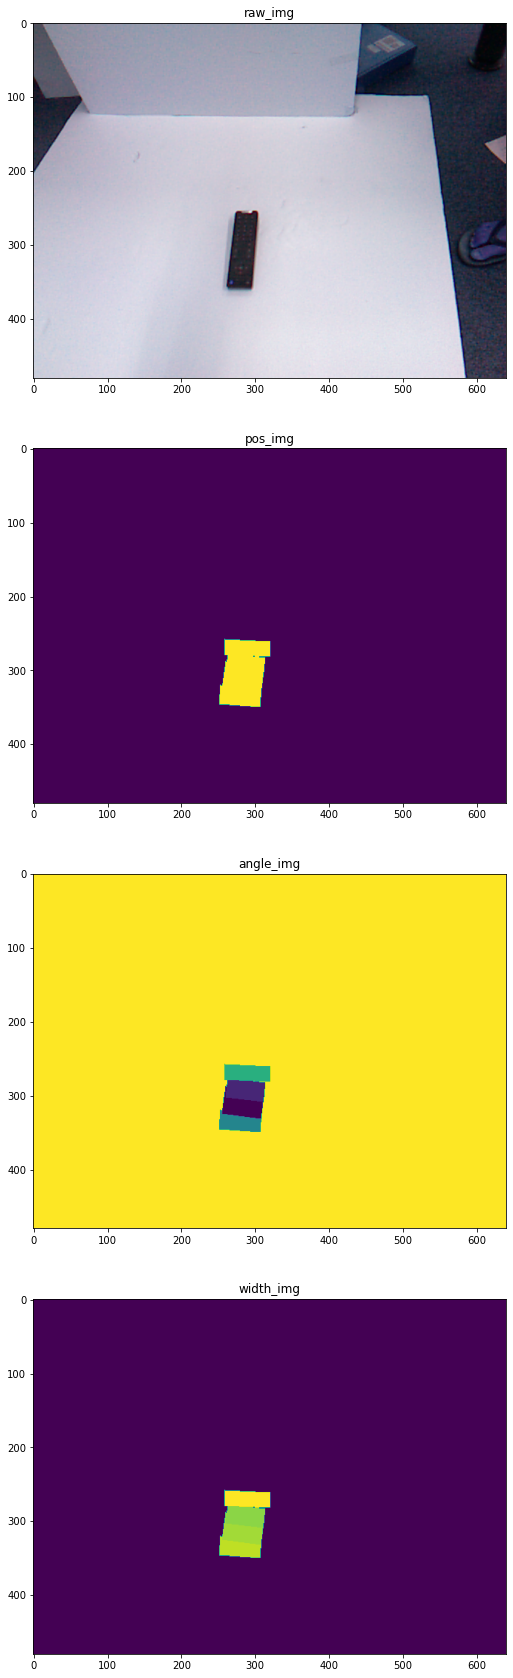

In [300]:
plt.figure(figsize = (30,30))
plt.subplot(411)
plt.imshow(cv2.imread(rgb_path[0]))
plt.title('raw_img')
print(cv2.imread(rgb_path[0]).shape)

plt.subplot(412)
plt.imshow(pos_img)
plt.title('pos_img')

plt.subplot(413)
plt.imshow(angle_img)
plt.title('angle_img')

plt.subplot(414)
plt.imshow(width_img)
plt.title('width_img')

plt.show()

上面的方法还是集成度不够，需要先用函数读取框然后再生成类，下面给类添加一个从源文件载入的函数load_from_cornell_files

In [ ]:
class Grasps:
    '''定义一个多抓取框处理类，主要功能是从原始的标注文件中读出多个抓取框并将其构建成多个单一的抓取框Grasp类，同时能够对这些属于同一对象的多个抓取框对象进行一些数据的统一集成处理'''
    def __init__(self,grs = None):
        '''
        :功能     : 多抓取框类初始化函数，功能是将属于一个对象的多个单独的抓取框集成到一个类里面来。
        :参数 grs : list,包含一个对象中多个抓取框类的列表
        '''
        if grs:
            self.grs = grs
        else:
            self.grs = []
    
    @classmethod
    def load_from_cornell_files(cls,cornell_grasp_files):
        '''
        :功能     : 从一个graspf文件中读取载入多个抓取框并构建成为这个类（其实就是从之前的那个get_rectangles改的）
        :参数 grs : list,包含一个对象中多个抓取框类的列表
        '''
        grasp_rectangles = []
        with open(cornell_grasp_files,'r') as f:
            while True:
                grasp_rectangle = []
                point0 = f.readline().strip()
                if not point0:
                    break
                point1,point2,point3 = f.readline().strip(),f.readline().strip(),f.readline().strip()
                if point0[0] == 'N':#后面发现有些坐标点坐标是NaN，会报错，这里处理一下，暂时还不晓得gg-cnn里面怎么处理的
                    break
                grasp_rectangle = np.array([str2num(point0),
                               str2num(point1),
                               str2num(point2),
                               str2num(point3)])
                grasp_rectangles.append(Grasp(grasp_rectangle))#找出各个框后就直接用它构造Grasp对象了

            return cls(grasp_rectangles)#返回实例化的类
        
    def generate_img(self,pos = True,angle = True,width = True,shape = (480,640)):
        '''
        :功能       :将本对象的多个的抓取框信息融合并生成指定的映射图，以这种方式返回定义一个抓取的多个参数，包括中心点，角度，宽度
        :参数 pos   :bool,是否生成返回位置映射图
        :参数 angle :bool,是否生成返回角度映射图
        :参数 width :bool,是否生成返回夹爪宽度映射图
        :参数 shape :tuple
        :返回       :融合本对象的多个抓取框信息的映射图
        '''
        
        if pos:
            pos_out = np.zeros(shape)
        else:
            pos_out = None
        if angle:
            angle_out = np.zeros(shape)
        else:
            angle_out = None
        if width:
            width_out = np.zeros(shape)
        else:
            width_out = None
        
        for gr in self.grs:
            rr,cc = gr.compact_polygon_coords(shape)#shape的指定还是很重要的，可以考虑图像边界
            
            if pos:
                pos_out[cc,rr] = 1.0
            if angle:
                angle_out[cc,rr] = gr.angle
            if width:
                width_out[cc,rr] = gr.width

        return pos_out,angle_out,width_out


In [ ]:
grasps = Grasps.load_from_cornell_files(cpos_path[0])

In [ ]:
pos_img,angle_img,width_img = grasps.generate_img(shape = (480,640))
plt.subplot(141)
plt.imshow(cv2.imread(rgb_path[0]))
plt.title('raw_img')

plt.subplot(142)
plt.imshow(pos_img)
plt.title('pos_img')

plt.subplot(143)
plt.imshow(angle_img)
plt.title('angle_img')

plt.subplot(144)
plt.imshow(width_img)
plt.title('width_img')

plt.show()


可以看到，结果输出是一样的，这个类到目前位置就定义完了，Grasp这个类是针对一个抓取框来将其坐标信息提取转化为中心坐标，角度，宽度等信息的，然后Grasps这个类是将输入同一个对象的多个抓取框信息整合的一个类|

#### 3. 数据集的封装
为了可以更方便地喂入torch的网络，最好使用torh的dataset和dataloader进行封装，这个之前做过一次了，不过用的是Iterable类，这里应该使用map类，不过都差不多，那么就定义一个cornell数据集载入类如下：

In [ ]:
# 另外，这个地方的一个难点在于，需要将输入和输出都添加封装进来，因为毕竟是数据集嘛，肯定要既有输入也要有target的
import torch
class Cornell(torch.utils.data.Dataset):
    def __init__(self,file_dir,include_depth=True,include_rgb=True,start = 0.0,end = 1.0):
        '''
        :功能               : 数据集封装类的初始化函数，功能包括数据集读取，数据集划分，其他参数初始化等
        :参数 file_dir      : str,按照官方文档的示例和之前的经验，这里需要读入数据集，所以需要指定数据的存放路径
        :参数 include_depth : bool,是否包含depth图像输入
        :参数 include_rgb   : bool,是否包含rgb图像输入
        :参数 start,end     : float,为了方便数据集的拆分，这里定义添加两个边界参数start,end
        :返回 None
        ''' 
        super(Cornell,self).__init__() # 执行父类的构造函数，可以使用父类的features

        # 参数传递
        self.include_depth = include_depth
        self.include_rgb = include_rgb

        # 去制定路径载入数据集数据
        cpos_path = glob.glob(os.path.join(file_dir, '*', 'pcd*cpos.txt'))
        cpos_path.sort()

        l = len(cpos_path)
        if l == 0:
            raise FileNotFoundError('没有找到数据集请检查路径'.format(file_dir))
        
        rgb_path = [filename.replace('cpos.txt','r.png') for filename in cpos_path]
        depth_path = [filename.replace('cpos.txt','d.tiff') for filename in cpos_path]

        # 按照边界参数对数据集进行划分并定义为类的属性
        self.cpos_path = cpos_path[int(start*l): int(end*l)]
        self.rgb_path = rgb_path[int(start*l): int(end*l)]
        self.depth_path = depth_path[int(start*l): int(end*l)]

    @staticmethod # 不用实例化可以直接调用
    def numpy_to_torch(s):
        '''
        :功能     :将输入的numpy数组转化为torch张量，并指定数据类型，如果数据没有channel维度，就给它加上这个维度
        :参数 s   :numpy ndarray,要转换的数组
        :返回     :tensor,转换后的torch张量
        '''
        if len(s.shape) == 2:
            return torch.from_numpy(np.expand_dims(s, 0).astype(np.float32))
        else:
            return torch.from_numpy(s.astype(np.float32))
    
    def get_rgb(self,idx):
        '''
        :功能     :读取返回指定id的rgb图像
        :参数 idx :int,要读取的数据id
        :返回     :ndarray,处理好后的rgb图像
        '''
        rgb_img = Image.from_file(self.rgb_path[idx])
        rgb_img.normalize()

        return rgb_img.img

    def get_depth(self,idx):
        '''
        :功能     :读取返回指定id的depth图像
        :参数 idx :int,要读取的数据id
        :返回     :ndarray,处理好后的depth图像
        '''
        #目前这个DepthImage类还没有定义，后面仿照Image类给它定义一下
        depth_img = DepthImage.from_file(self.depth_path[idx])
        depth_img.normalize()
        
        return depth_img.img
    
    def get_grasp(self,idx):
        '''
        :功能       :读取返回指定id的抓取标注参数并将多个抓取框的参数返回融合
        :参数 idx   :int,要读取的数据id
        :参数 pos   :bool,是否生成返回位置映射图
        :参数 angle :bool,是否生成返回角度映射图
        :参数 width :bool,是否生成返回夹爪宽度映射图
        :返回       :以图片的方式返回定义一个抓取的多个参数，包括中心点，角度，宽度和长度
        '''
        grasps_rectangles = Grasps.load_from_cornell_files(self.cpos_path[idx])
        pos_img, angle_img, width_img = grasps_rectangles.generate_img(shape = (480, 640))

        return pos_img, angle_img, width_img
    
    # torch数据集中必须包含可以索引每个item的函数
    def __getitem__(self,idx):
        # 载入深度图像
        if self.include_depth:
            depth_img = self.get_depth(idx)
            x = self.numpy_to_torch(depth_img)
        # 载入rgb图像
        if self.include_rgb:
            rgb_img = self.get_rgb(idx)
            #torch是要求channel-first的，检测一下，如果读进来的图片是channel-last就调整一下，ggcnn中目前我没看到在哪调整的，但肯定是做了的
            if rgb_img.shape[2] == 3:
                rgb_img = np.moveaxis(rgb_img,2,0)
            x = self.numpy_to_torch(rgb_img)
        if self.include_depth and self.include_rgb:#如果灰度信息和rgb信息都要的话，就把他们堆到一起构成一个四通道的输入，
            x = self.numpy_to_torch(
                np.concatenate(
                    (np.expand_dims(depth_img,0),rgb_img),0
                )
            )
        # 载入抓取标注数据
        pos_img, angle_img, width_img = self.get_grasp(idx)
        # 处理一下角度信息，因为这个角度值区间比较大，不怎么好处理，所以用两个三角函数把它映射一下：
        cos_img = self.numpy_to_torch(np.cos(2*angle_img))
        sin_img = self.numpy_to_torch(np.sin(2*angle_img))
        
        pos_img = self.numpy_to_torch(pos_img)
        
        # 限定抓取宽度范围并将其映射到[0,1]
        width_img = np.clip(width_img, 0.0, 150.0)/150.0
        width_img = self.numpy_to_torch(width_img)
        
        # 返回 x 申请网络的输入，可以是only_rgb，也可以是only_depth, 还可以是depth+rgb 四通道输入
        return x,(pos_img,cos_img,sin_img,width_img)
        # 数据集iterable的数据 x NN 的输入，(pos_img,cos_img,sin_img,width_img)抓取点参数的映射图
    
    # torch数据集中必须包含可以返回数据集长度的量
    def __len__(self):
        return len(self.cpos_path)

In [ ]:
cornell_dataset = Cornell('../../../../grasping_dataset/Conell_grasping_dataset')

In [ ]:


dataset = torch.utils.data.DataLoader(cornell_dataset,batch_size = 64)



In [ ]:
for x,y in dataset:
    print(x.shape,y[0].shape,y[1].shape,y[2].shape,y[3].shape)
    break

#### 4.网络模型的建立
数据集处理封装完毕之后，问题的关键就到了建立网络模型预测的阶段，相对而言，这块要跑通的话是比较容易的，关键就是效果好不好的问题，网络名称和结构直接照搬GG-CNN的即可，开干。

In [290]:
import torch.nn.functional as F

#网络参数定义
filter_sizes = [32, 16, 8, 8, 16, 32]
kernel_sizes = [9, 5, 3, 3, 5, 9]
strides = [3, 2, 2, 2, 2, 3]

class GGCNN(torch.nn.Module):
    #定义抓取预测模型的结构、前向传递过程以及损失计算
    def __init__(self, input_channels=1):
        '''
        :功能                  :类初始化函数
        :参数 input_channels   :int,输入数据的通道数，1或3或4
        :返回                  :None
        '''
        super(GGCNN,self).__init__()

        # 网络结构定义
        self.conv1 = torch.nn.Conv2d(input_channels, filter_sizes[0], kernel_sizes[0], stride=strides[0], padding=3)
        self.conv2 = torch.nn.Conv2d(filter_sizes[0], filter_sizes[1], kernel_sizes[1], stride=strides[1], padding=2)
        self.conv3 = torch.nn.Conv2d(filter_sizes[1], filter_sizes[2], kernel_sizes[2], stride=strides[2], padding=1)

        
        self.convt1 = torch.nn.ConvTranspose2d(filter_sizes[2], filter_sizes[3], kernel_sizes[3], stride=strides[3], padding=1, output_padding=1)
        self.convt2 = torch.nn.ConvTranspose2d(filter_sizes[3], filter_sizes[4], kernel_sizes[4], stride=strides[4], padding=2, output_padding=1)
        self.convt3 = torch.nn.ConvTranspose2d(filter_sizes[4], filter_sizes[5], kernel_sizes[5], stride=strides[5], padding=3, output_padding=1)

        self.pos_output = torch.nn.Conv2d(filter_sizes[5], 1, kernel_size=2)
        self.cos_output = torch.nn.Conv2d(filter_sizes[5], 1, kernel_size=2)
        self.sin_output = torch.nn.Conv2d(filter_sizes[5], 1, kernel_size=2)
        self.width_output = torch.nn.Conv2d(filter_sizes[5], 1, kernel_size=2)

        #使用Glorot/Xavier初始化法初始化权重
        # 遍历NN的所有Module包括所有层和嵌套层
        for m in self.modules():
            # 对于每个模块检查其是否是'torch.nn.Conv2d' or 'torch.nn.ConvTranspose2d'的实例
            if isinstance(m, (torch.nn.Conv2d, torch.nn.ConvTranspose2d)):
                # 如果是指定模块之一，他使用'torch.nn.init.xavier_uniform_'初始化权重'm.weight'
                # 从一个均匀分布中采样权重， 该均匀分布由输入和输出的维度决定
                # gain=1 设置增益参数的值，增益参数是权重的缩放因子
                torch.nn.init.xavier_uniform_(m.weight, gain=1)

    def forward(self, x):
        '''
        :功能     :前向传播函数
        :参数 x   :tensors,一次网络输入
        :返回     :tensors，各参数的预测结果
        '''
        print('checkpoint1')
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.convt1(x))
        x = F.relu(self.convt2(x))
        x = F.relu(self.convt3(x))

        pos_output = self.pos_output(x)
        cos_output = self.cos_output(x)
        sin_output = self.sin_output(x)
        width_output = self.width_output(x)

        return pos_output, cos_output, sin_output, width_output
        
    def compute(self, xc, yc):
        '''
        :功能      :损失计算函数
        :参数 xc   :tensors,一次网络输入
        :参数 yc   :tensors,网络输入对应真实标注信息
        :返回      :dict，各损失和预测结果
        '''
        y_pos, y_cos, y_sin, y_width = yc
        pos_pred, cos_pred, sin_pred, width_pred = self.forward(xc)

        p_loss = F.mse_loss(pos_pred, y_pos)
        cos_loss = F.mse_loss(cos_pred, y_cos)
        sin_loss = F.mse_loss(sin_pred, y_sin)            
        width_loss = F.mse_loss(width_pred, y_width)

        return {
            'loss': p_loss + cos_loss + sin_loss + width_loss,
            'losses': {
                'p_loss': p_loss,
                'cos_loss': cos_loss,
                'sin_loss': sin_loss,
                'width_loss': width_loss
            },
            'pred': {
                'pos': pos_pred,
                'cos': cos_pred,
                'sin': sin_pred,
                'width': width_pred
            }
        }


In [291]:
# 实例化网络
net = GGCNN(input_channels=4)

#### 5.如何进行网络的损失计算
测试网络的输出

In [292]:
#首先准备好一个样本的数据
cornell_data = Cornell('../../../../grasping_dataset/Conell_grasping_dataset')
dataset = torch.utils.data.DataLoader(cornell_data,batch_size = 1)
for x,y in dataset:
    xc = x
    print(type(xc))
    yc = y
    print(type(yc))
    break


<class 'torch.Tensor'>
<class 'list'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 4, 480, 640])
torch.Size([1, 1, 480, 640]) torch.Size([1, 1, 480, 640]) torch.Size([1, 1, 480, 640]) torch.Size([1, 1, 480, 640])
[[[   1.    1.    1. ...    1.    1.    1.]
  [   1.    1.    1. ...    1.    1.    1.]
  [   1.    1.    1. ...    1.    1.    1.]
  ...
  [  -0.   -0.   -0. ...   -0.   -0.   -0.]
  [  -0.   -0.   -0. ...   -0.   -0.   -0.]
  [  -0.   -0.   -0. ...   -0.   -0.   -0.]]

 [[ -82.  -82.  -81. ... -162. -161. -159.]
  [ -81.  -81.  -80. ... -162. -162. -161.]
  [ -79.  -79.  -79. ... -162. -162. -162.]
  ...
  [  44.   44.   46. ...  -99.  -97.  -95.]
  [  43.   43.   46. ... -103. -101.  -99.]
  [  43.   43.   46. ... -103. -101.  -99.]]

 [[ -92.  -91.  -90. ... -165. -167. -166.]
  [ -92.  -91.  -91. ... -163. -165. -165.]
  [ -91.  -92.  -91. ... -163. -162. -163.]
  ...
  [  33.   32.   32. ... -121. -120. -120.]
  [  32.   31.   32. ... -124. -123. -121.]
  [  31.   30.   32. ... -125. -123. -120.]]]


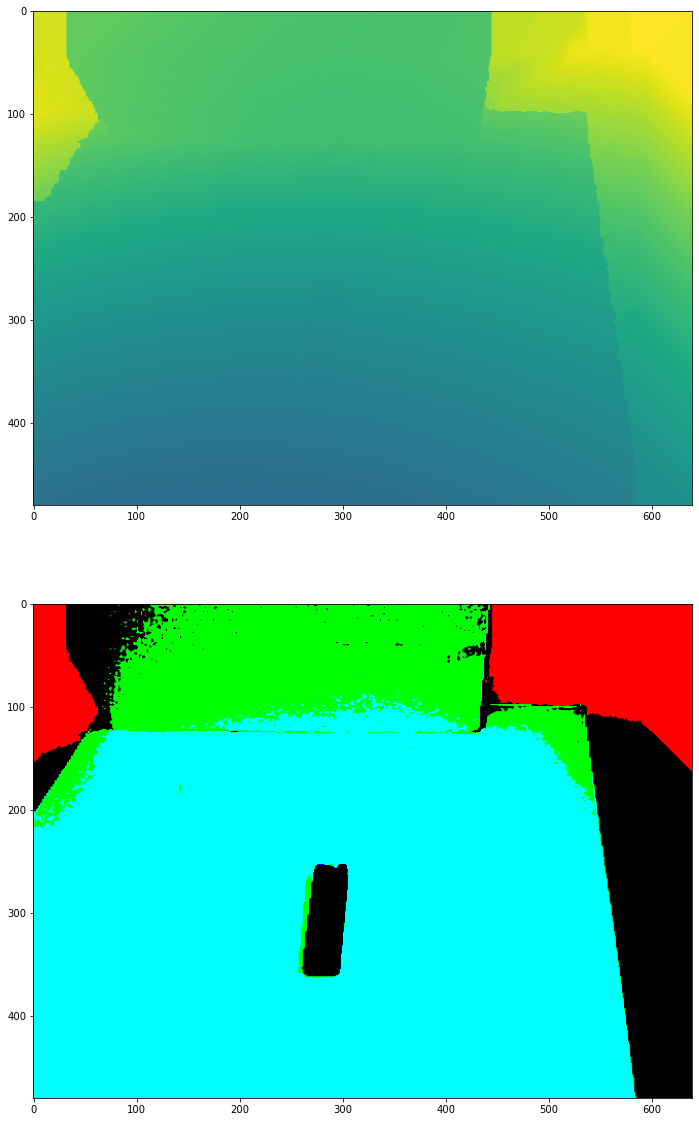

In [293]:
#先看一下形状
print(xc.shape)
print(yc[0].shape,yc[1].shape,yc[2].shape,yc[3].shape)

plt.figure(figsize = (20,20))
plt.subplot(211)
plt.imshow(xc[0][0].numpy())
plt.subplot(212)
print((xc[0][0:3].numpy()*255).round())
plt.imshow(np.moveaxis((xc[0][0:3].numpy()*255).round(),0,2))
# plt.show()

In [294]:
yc[0].shape

torch.Size([1, 1, 480, 640])

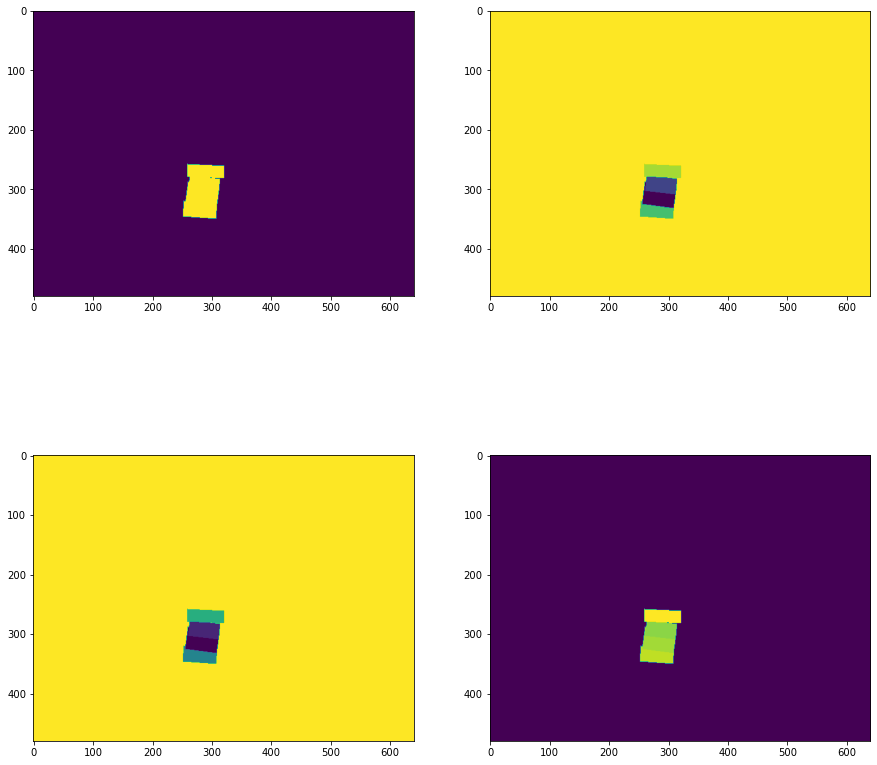

In [295]:
plt.figure(figsize = (15,15))
plt.subplot(221)
plt.imshow(yc[0][0][0].data.numpy())
plt.subplot(222)
plt.imshow(yc[1][0][0].data.numpy())
plt.subplot(223)
plt.imshow(yc[2][0][0].data.numpy())
plt.subplot(224)
plt.imshow(yc[3][0][0].data.numpy())

plt.show()

In [296]:
# 测试网络输出维度
net = GGCNN(4)

In [298]:
print(type(xc))
pos, cos, sin, width = net.forward(xc)

print(pos.shape, cos.shape, sin.shape, width.shape)

<class 'torch.Tensor'>
checkpoint1
torch.Size([1, 1, 480, 648]) torch.Size([1, 1, 480, 648]) torch.Size([1, 1, 480, 648]) torch.Size([1, 1, 480, 648])


上面输出结果torch.Size([1, 1, 480, 648])可见，CNN输出的图片尺寸与标定的图片torch.Size([1, 1, 480, 640])尺寸存在差距，解决方式有俩，要么调节网络的参数使得输出匹配，要么调节输入的尺寸让它来经过这个网络之后能输出合适的参数。